In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iasa-risks-pr/prophet_preds(2).csv
/kaggle/input/iasa-risks-pr/prophet_preds.csv
/kaggle/input/iasa-risks-pr/prophet_preds(1).csv


In [5]:
!pip install hurst
!pip install stockstats

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [6]:
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from keras.models import load_model
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
import matplotlib as mpl
from fbprophet import Prophet
import tqdm
import sympy as sym
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import gc   
from hurst import compute_Hc, random_walk
import plotly.graph_objects as go
from stockstats import StockDataFrame as Sdf

In [8]:
%%time
company = "INTC"
start = pd.Timestamp("1980-03-28")
end = pd.Timestamp("2020-11-28")
df = pd.DataFrame(columns=['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'])
df = web.DataReader(company, 'yahoo', start, end)
df.to_csv("df.csv")

CPU times: user 481 ms, sys: 11.4 ms, total: 493 ms
Wall time: 1.62 s


In [9]:
stock_df = Sdf.retype(df)

signal = stock_df['macds']        
macd   = stock_df['macd']        

listLongShort = [0]

for i in range(1, len(signal)):
    #                          # if the MACD crosses the signal line upward
    if macd[i] > signal[i] and macd[i - 1] <= signal[i - 1]:
        listLongShort.append(1)
    #                          # the other way around
    elif macd[i] < signal[i] and macd[i - 1] >= signal[i - 1]:
        listLongShort.append(-1)
    #                          # do nothing if not crossed
    else:
        listLongShort.append(0)

df['advice'] = listLongShort
df['advice'] = df['advice'].astype(np.int8)

cols = [
        "rsi_15", "rsi_25", "rsi_40", "macd", "boll_ub", "boll_lb", 
        "dma", "cci_15", "cci_25", "open_10_ema", "open_10_mvar", "open_20_ema", "open_20_mvar",
        "tr", "atr", "vr", "tema", "open_10_sma", "open_10_mstd", "open_20_sma", "open_20_mstd",
        "cr", "cr-ma1", "cr-ma2", "cr-ma3", "trix",
        "wr_15", "wr_25", "wr_40", "kdjk"
       ]
for col in cols:
    df[col] = stock_df[col]
    
df["open_pct_change"] = df["open"].pct_change()

df.dropna(inplace=True)

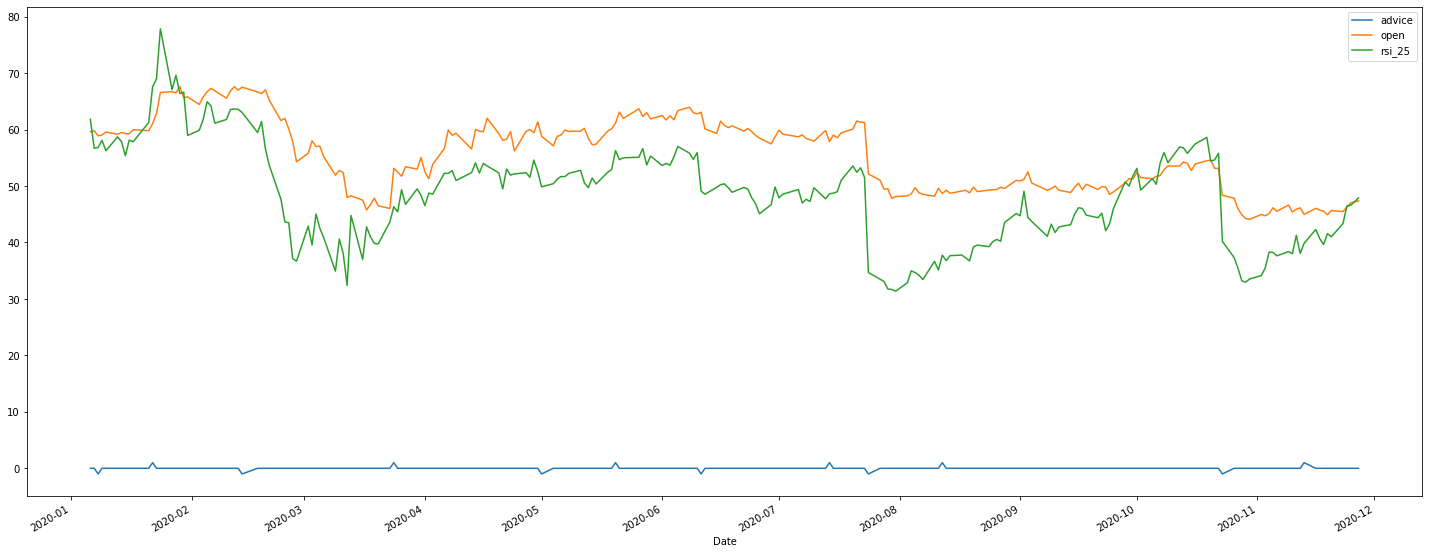

In [22]:
df.loc[df.index >pd.Timestamp("2020-01-05"),["advice", "open", "rsi_25"]].plot(figsize=(25,10));

In [42]:
def mark_func(y):
    mark_y = (y.groupby(["class_open", "class_open_lag_1"]).count() / (y.shape[0]))["open"].reset_index()
    pivot = mark_y.pivot_table(index=["class_open"], columns=["class_open_lag_1"], values="open")
    pivot = pivot.apply(lambda x: x/x.sum(), axis=1)
    pivot.fillna(0, inplace=True)
    
    j = sym.Symbol('j')
    i = sym.Symbol('i')
    m = sym.Matrix([[f"m_{i}" for i in range(pivot.shape[0])]]).T
    P = sym.Matrix(pivot.values)
    
    solutions = []
    for k in range(pivot.shape[0]):
        solution = sym.solve((m[i] - 1 - sum([(P[i,j]*m[j]) for j in range(pivot.shape[0])]) if i!=k else m[i] for i in range(pivot.shape[0])), tuple((m[i] for i in range(pivot.shape[0]))))
        solutions.append(solution)
        
    exps = pd.DataFrame(solutions, index=pivot.index)
    exps.columns = pivot.columns
    return exps

In [73]:
%%time

__df = df.copy()
__df = __df[(__df.index >= pd.Timestamp("2019-01-21")) & (__df.index <= pd.Timestamp("2020-08-09"))]
__df = df.copy()
__df["open_pct_change"] = __df["open"].pct_change()

__df.dropna(inplace=True)

__df["class_open"] = __df["open_pct_change"].clip(-0.05,0.05).apply(lambda x: int(x*100))
__df["class_open_lag_1"] = __df["class_open"].shift(1)
__df.dropna(inplace=True)

__df["class_open_lag_1"] = __df["class_open_lag_1"].astype(int)
tqdm.tqdm.pandas()

troll = []
window = 50
for ind in range(0, (__df.shape[0] - window)*0 + 9, 1):
    y = __df.reset_index().loc[ind:ind+window].copy() # , ["Open", "close", "class_open", "class_open_lag_1"]
    mark_y = (y.groupby(["class_open", "class_open_lag_1"]).count() / (y.shape[0]))["open"].reset_index()
    pivot = mark_y.pivot_table(index=["class_open"], columns=["class_open_lag_1"], values="open")
    pivot = pivot.progress_apply(lambda x: x/x.sum(), axis=1)
    pivot.fillna(0, inplace=True)
    
    j = sym.Symbol('j')
    i = sym.Symbol('i')
    m = sym.Matrix([[f"m_{i}" for i in range(pivot.shape[0])]]).T
    P = sym.Matrix(pivot.values)
    
    solutions = []
    for k in range(pivot.shape[0]):
        solution = sym.solve((m[i] - 1 - sum([(P[j,i]*m[j]) for j in range(pivot.shape[0])]) if i!=k else m[i] for i in range(pivot.shape[0])), tuple((m[i] for i in range(pivot.shape[0]))))
        solutions.append(solution)

    exps = pd.DataFrame(solutions, index=pivot.index)
    #exps.columns = pivot.columns
    
    exps["window"] = ind
    troll.append(exps)
    
tr = pd.concat(troll)
tr.fillna(0, inplace=True)
tr.reset_index(inplace=True)
tr.to_csv("troll.csv")

#tr.loc[tr.class_open == 5, -4].astype(float).plot()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 5/5 [00:00<00:00, 1397.45it/s]


CPU times: user 3.06 s, sys: 27.1 ms, total: 3.09 s
Wall time: 3.06 s


In [74]:
%%time
__df['window_index'] = __df.reset_index().index.values // 250
roll = __df.groupby(["window_index"], axis=0).apply(mark_func)
roll.reset_index(inplace=True)
roll.fillna(0, inplace=True)

roll[roll["window_index"] == 0]

roll.loc[(roll["class_open"] > 0), ["window_index",-5,-4,-3,-2,-1,0]]

CPU times: user 2min 27s, sys: 14.2 ms, total: 2min 27s
Wall time: 2min 27s


class_open_lag_1,window_index,-5,-4,-3,-2,-1,0
6,0,9.04169901461216,9.47722544326069,10.0432322675589,8.67561662936782,9.46812069901918,8.47722544326069
7,0,11.3173966822213,16.6627085504999,16.2116634280939,14.1590158913600,15.8469462727576,15.6627085504999
8,0,21.0471436462127,23.4477690998482,23.4385735397773,22.7415449542886,22.7795343431154,22.4477690998482
9,0,50.6592595842842,49.6603921948418,50.8598419905623,50.7561077099844,50.5595749389223,48.6603921948418
10,0,40.4715810192076,49.1249492865296,48.7475832368415,48.2915849468508,49.2835592539838,48.1249492865296
...,...,...,...,...,...,...,...
424,40,9.74876736700398,9.34617732726670,9.57508090338836,8.74031020740586,8.71554027000558,8.02935448347519
425,40,9.19924590714030,10.7399721537392,9.46947808306878,9.03554644016669,8.91899843895552,9.80673958122595
426,40,34.1871686702264,21.7763437309771,30.6190306603251,33.3963615265004,32.4400629558328,34.3506793212296
427,40,60.8804946275453,48.8032792718984,60.3789456426033,59.6897995895506,57.7616834805401,59.4055711076104


In [75]:
roll

class_open_lag_1,window_index,class_open,-5,-4,-3,-2,-1,0,1,2,3,4,5
0,0,-5,0.0,42.9096919879290,37.0733389554955,36.7236267884354,40.7144089200442,41.9096919879290,39.2439628807601,39.3871576228479,41.0733971493171,41.9006782418966,40.8780064727531
1,0,-4,246.381444192965,0.0,242.429270183519,244.464440900442,237.450647676742,245.083375522739,245.526871813322,245.655789275544,245.736903957426,246.312341023861,246.345894660779
2,0,-3,29.1300376498030,28.9048587653335,0.0,28.5334567978043,25.2932092250383,27.9048587653335,28.6093707784031,28.2272512081516,24.1191189021581,29.0338157424607,27.9825491540433
3,0,-2,26.3651273321843,32.2861931460794,32.3226310309934,0.0,32.5893353693813,31.2861931460794,30.9084258520526,31.6065500311913,29.6643104906012,32.4143359001242,26.4052776385645
4,0,-1,8.93079651622306,8.63272784599771,4.97862250677702,7.01379322369988,0.0,7.63272784599771,8.07622413658010,8.20514159880274,8.28625628068385,8.86169334711972,8.89524698403758
...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,40,1,9.74876736700398,9.34617732726670,9.57508090338836,8.74031020740586,8.71554027000558,8.02935448347519,0.0,9.26283610441972,8.07835692484456,9.51546381969399,10.5177569776780
425,40,2,9.19924590714030,10.7399721537392,9.46947808306878,9.03554644016669,8.91899843895552,9.80673958122595,9.16948301674792,0.0,10.4620626027947,8.16225640065464,8.60409458009793
426,40,3,34.1871686702264,21.7763437309771,30.6190306603251,33.3963615265004,32.4400629558328,34.3506793212296,33.7171568034160,34.6237198807457,0.0,35.1803600124263,32.8415310500417
427,40,4,60.8804946275453,48.8032792718984,60.3789456426033,59.6897995895506,57.7616834805401,59.4055711076104,60.5727381134265,60.4990581952285,60.1026270721355,0.0,46.7889031150424


class_open_lag_1,window_index,-5,-4,-3,-2,-1,0
6,0,9.04169901461216,9.47722544326069,10.0432322675589,8.67561662936782,9.46812069901918,8.47722544326069
7,0,11.3173966822213,16.6627085504999,16.2116634280939,14.1590158913600,15.8469462727576,15.6627085504999
8,0,21.0471436462127,23.4477690998482,23.4385735397773,22.7415449542886,22.7795343431154,22.4477690998482
9,0,50.6592595842842,49.6603921948418,50.8598419905623,50.7561077099844,50.5595749389223,48.6603921948418
10,0,40.4715810192076,49.1249492865296,48.7475832368415,48.2915849468508,49.2835592539838,48.1249492865296
...,...,...,...,...,...,...,...
424,40,9.74876736700398,9.34617732726670,9.57508090338836,8.74031020740586,8.71554027000558,8.02935448347519
425,40,9.19924590714030,10.7399721537392,9.46947808306878,9.03554644016669,8.91899843895552,9.80673958122595
426,40,34.1871686702264,21.7763437309771,30.6190306603251,33.3963615265004,32.4400629558328,34.3506793212296
427,40,60.8804946275453,48.8032792718984,60.3789456426033,59.6897995895506,57.7616834805401,59.4055711076104


In [86]:
#roll = tr
risks_arg = roll.loc[(roll["class_open"] > 0)][["window_index",-5,-4,-3,-2,-1,0]].groupby(["window_index"]).apply(lambda x: np.min(x.values[:,1:], axis=1))
risks_min = roll.loc[(roll["class_open"] > 0)][["window_index",-5,-4,-3,-2,-1,0]].groupby(["window_index"]).apply(lambda x: np.min(x.values, axis=0)[1:])
risks = pd.concat([pd.DataFrame(risks_arg),pd.DataFrame(risks_min)], axis=1)
risks.columns = ["ax1", "ax0"]
risks["best_scenario"] = risks["ax1"].apply(np.argmin)
risks["worst_scenario"] = risks["ax0"].apply(np.argmax)

dctax1 = {5:0, 4:1, 3:2, 2:3, 1:4, 0:5}

risks["best_scenario"] = risks["best_scenario"].replace(dctax1)
risks["worst_scenario"] = risks["worst_scenario"].replace(dctax1)

pd.options.plotting.backend = "plotly"
risks[["best_scenario", "worst_scenario"]].plot()

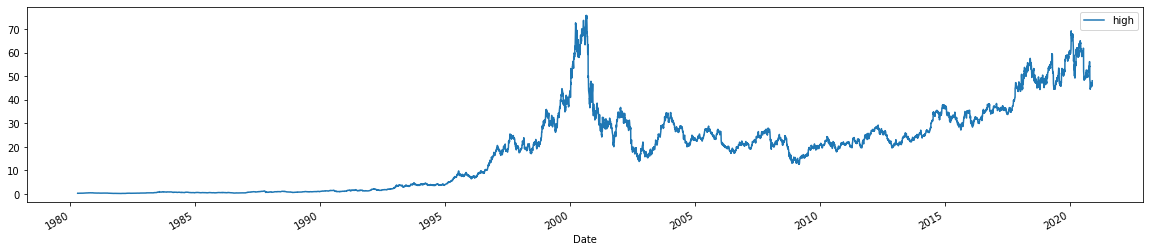

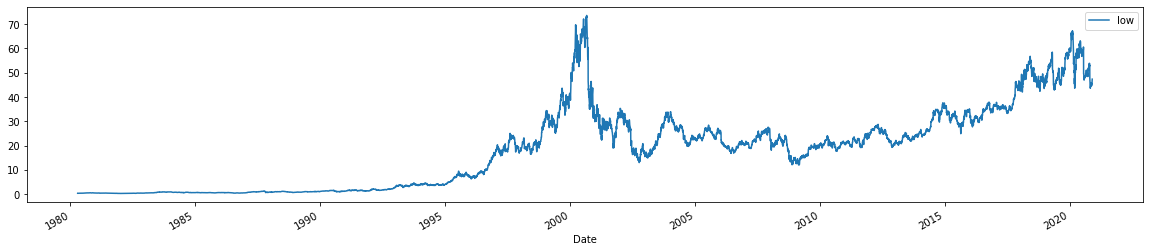

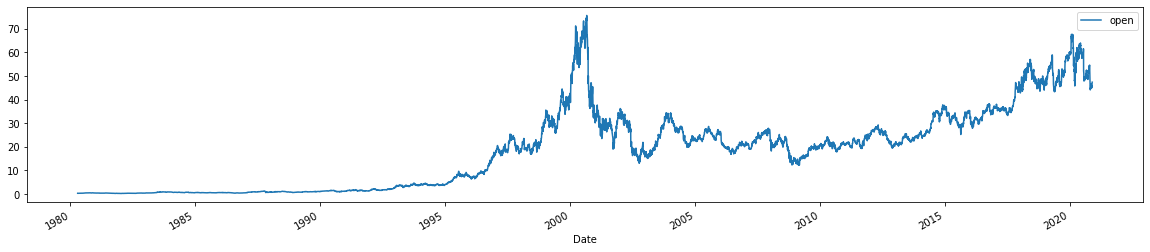

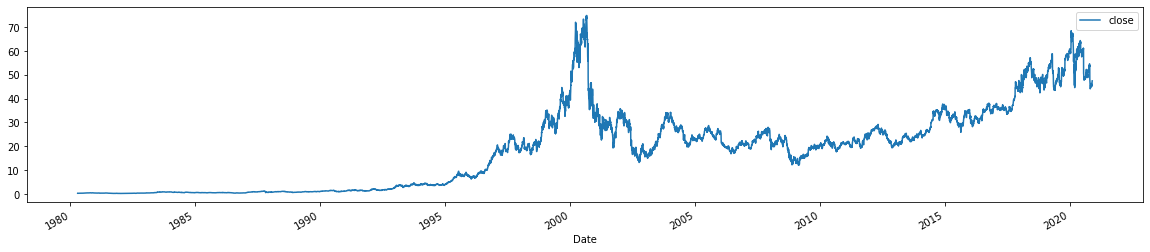

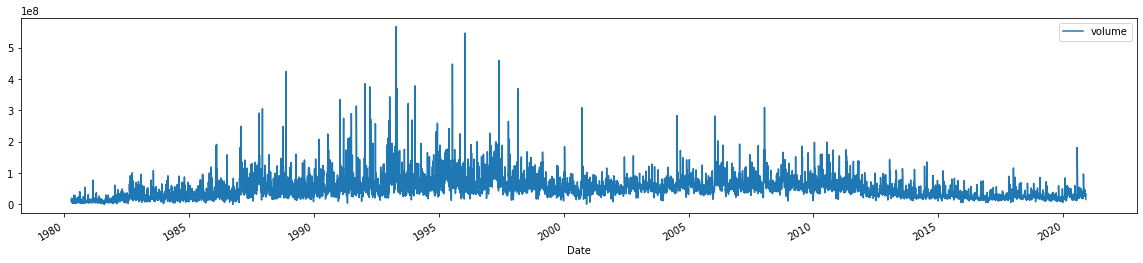

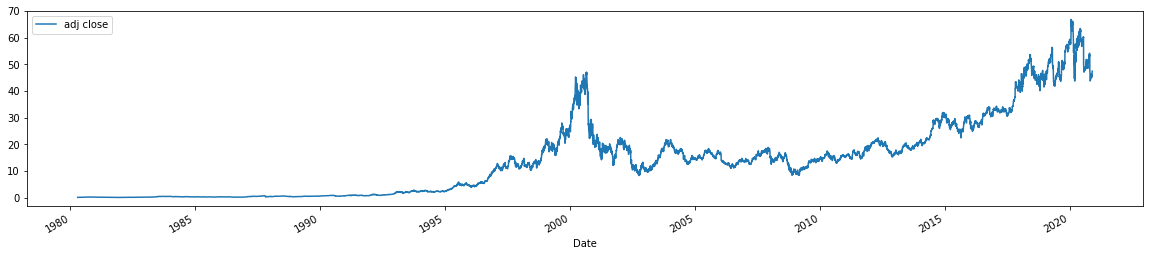

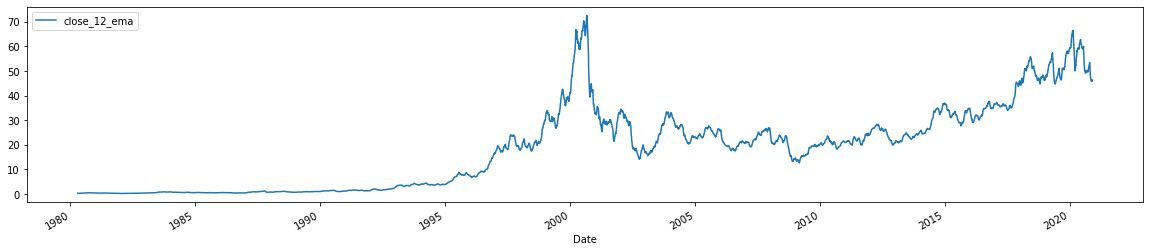

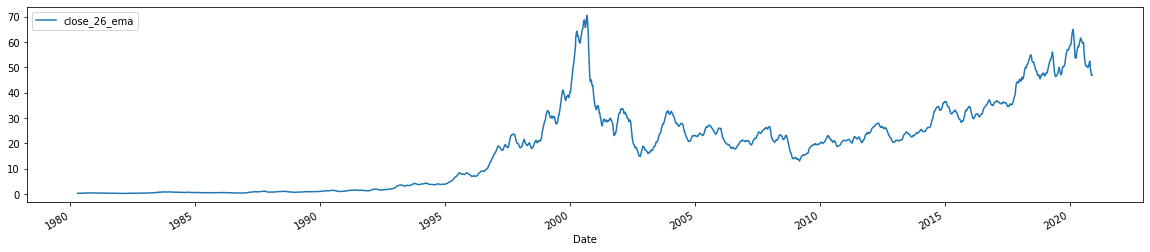

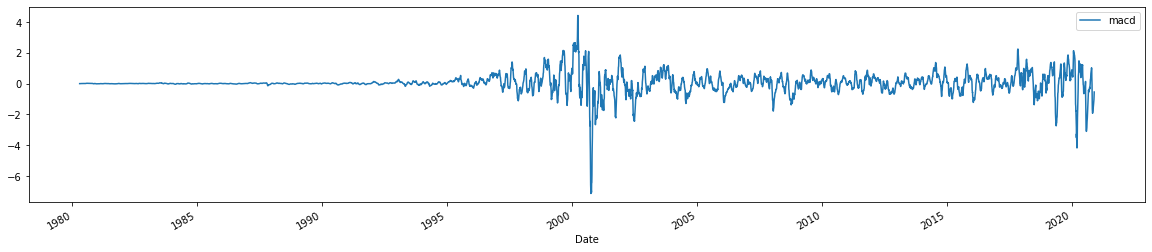

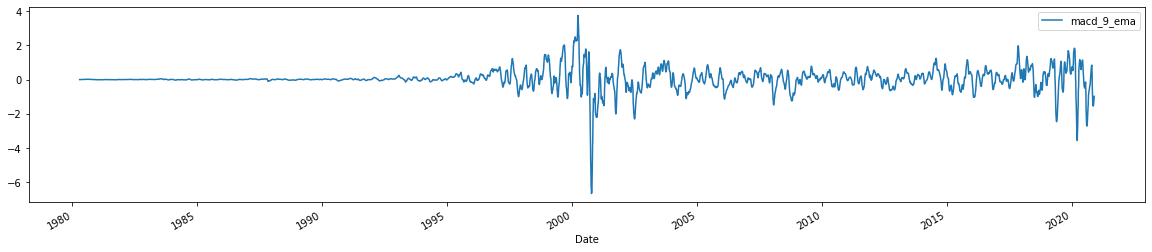

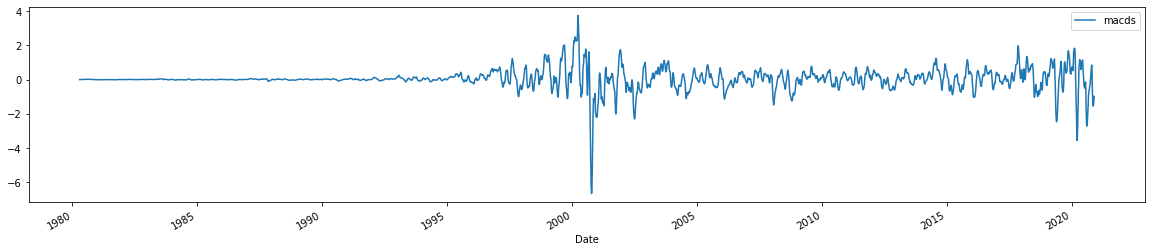

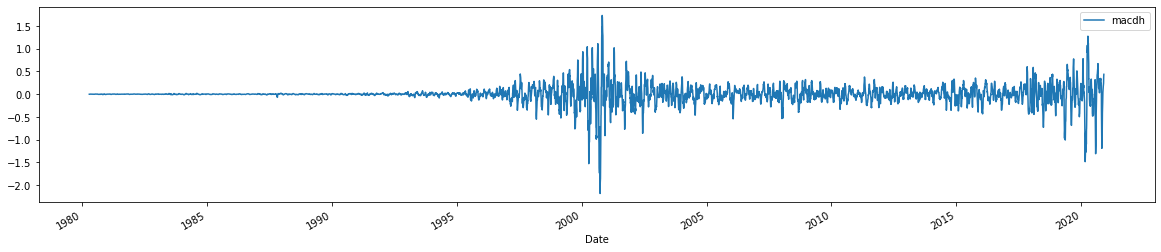

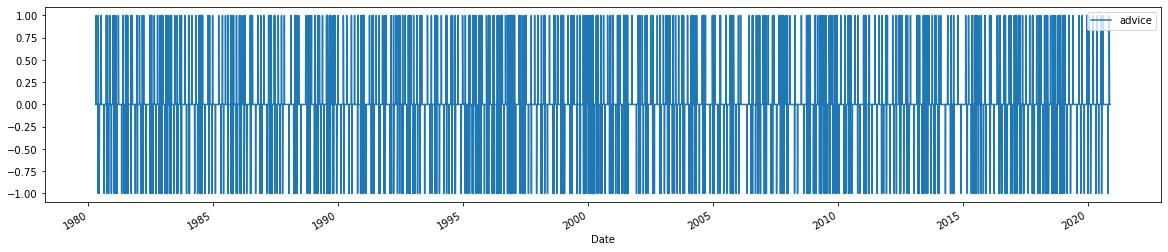

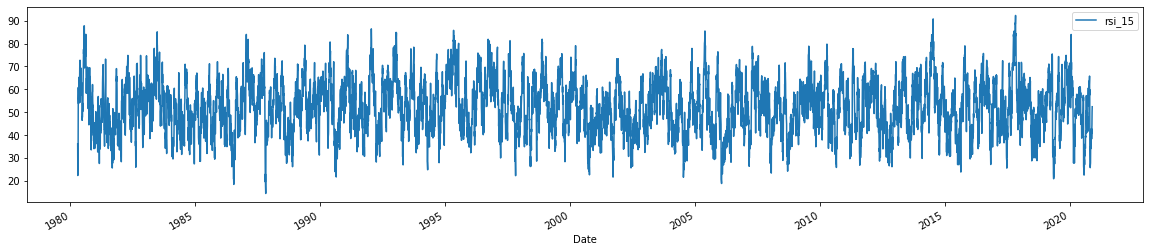

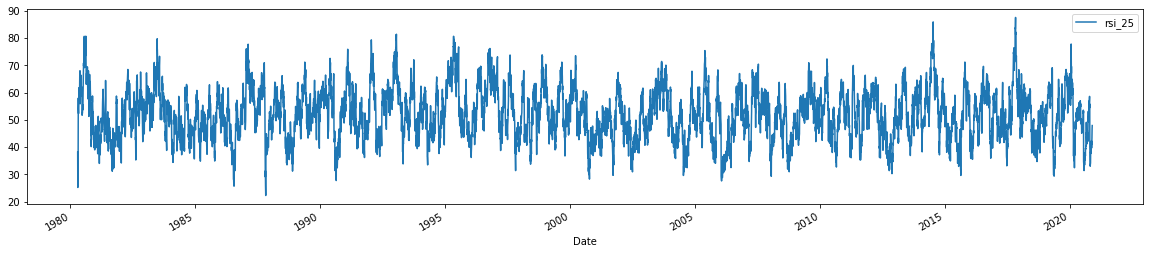

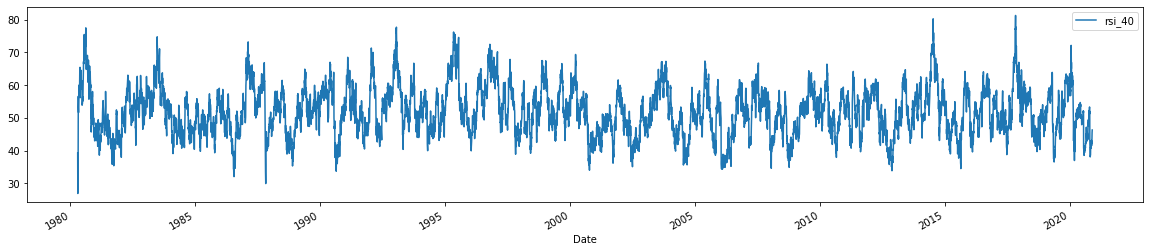

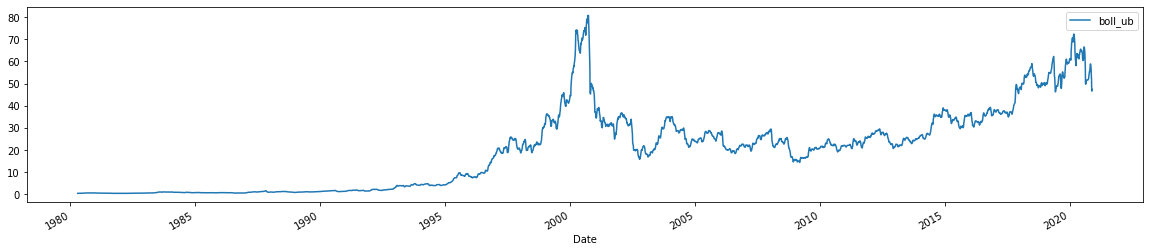

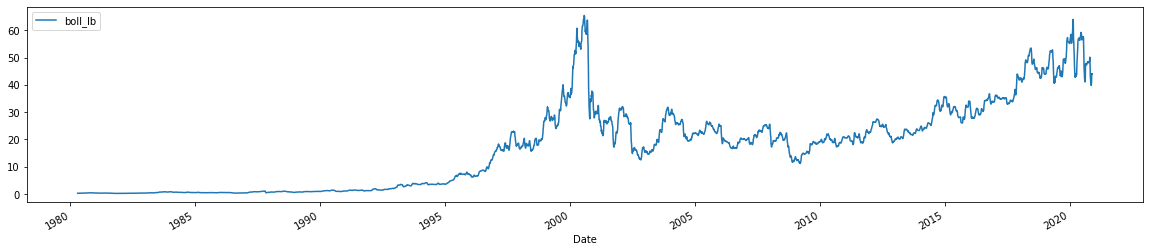

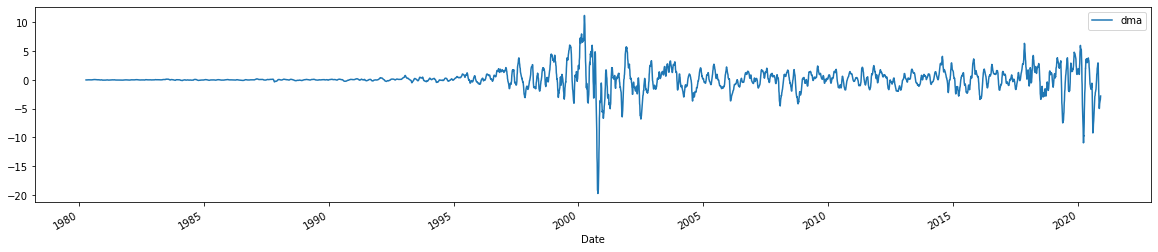

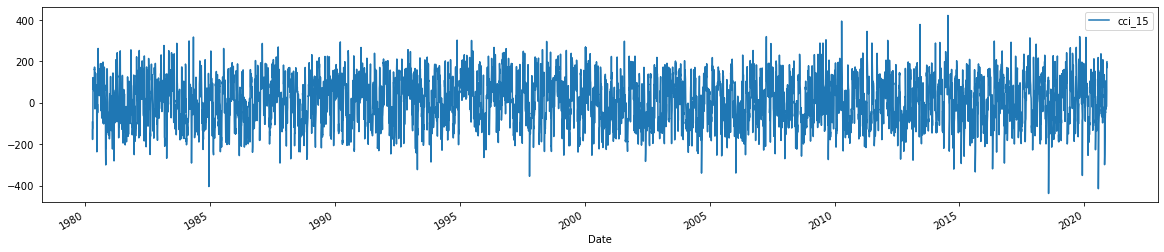

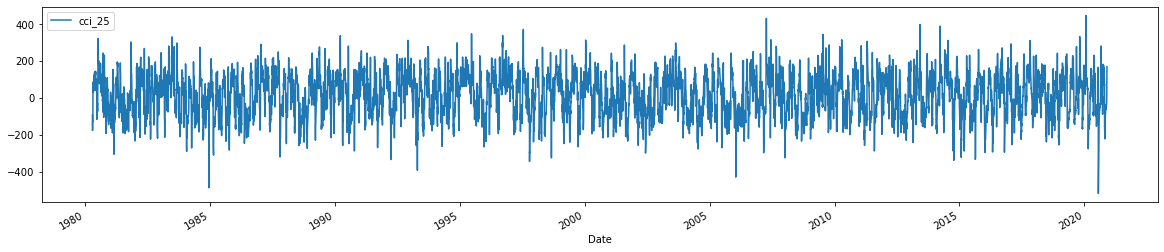

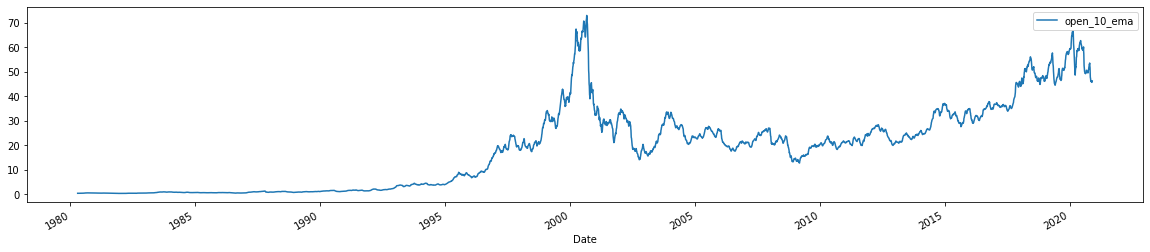

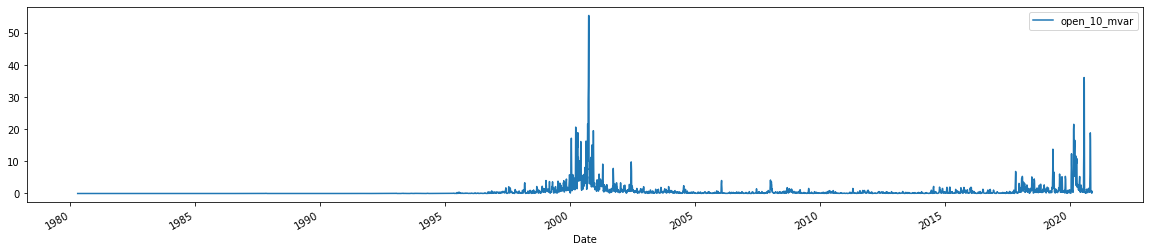

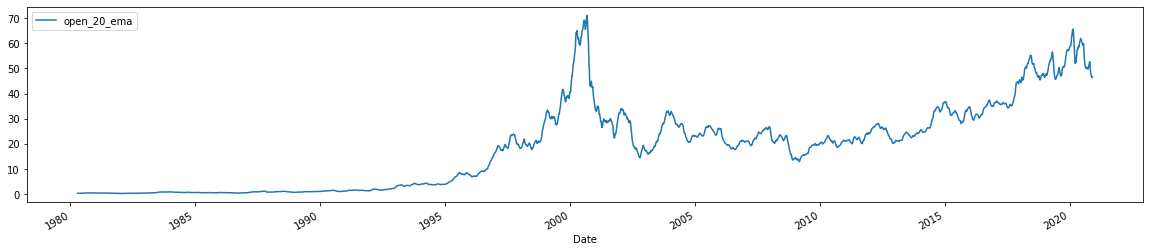

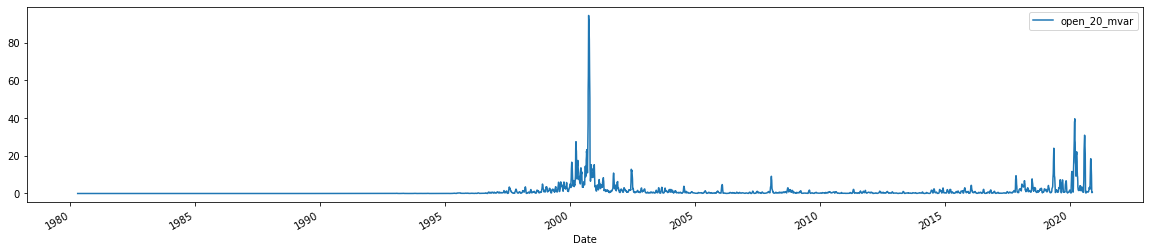

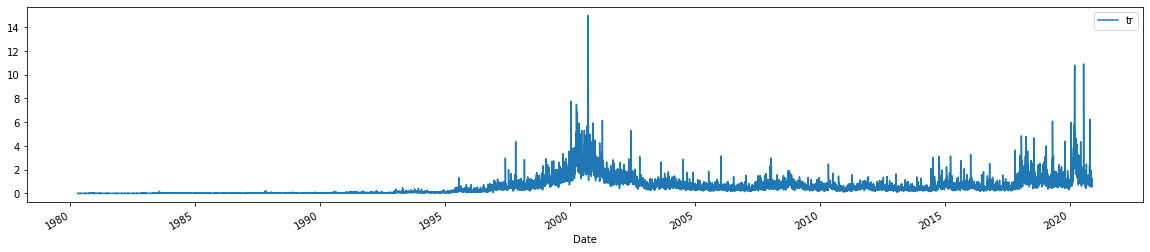

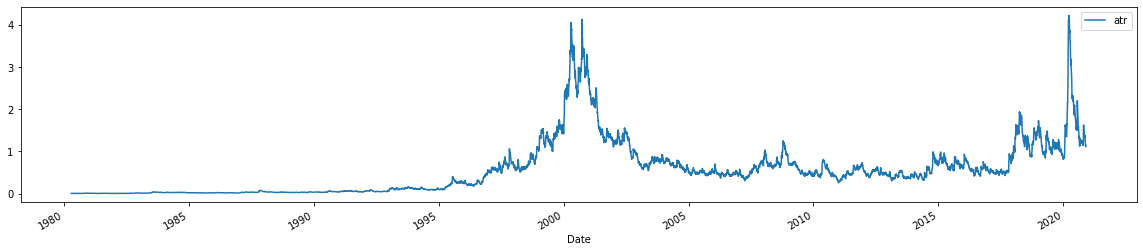

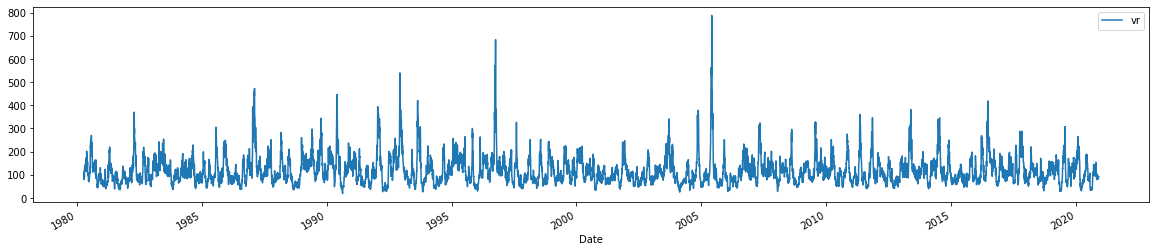

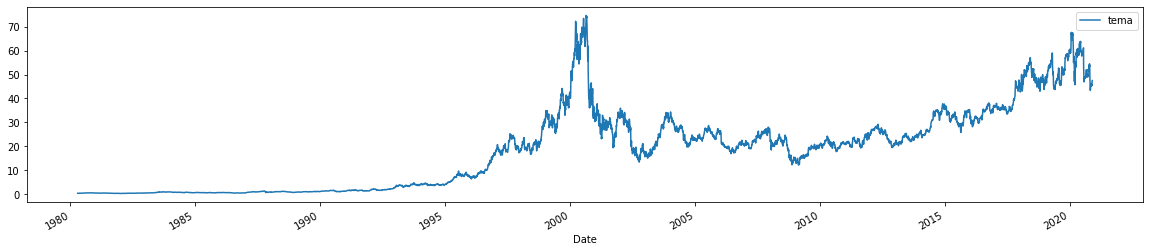

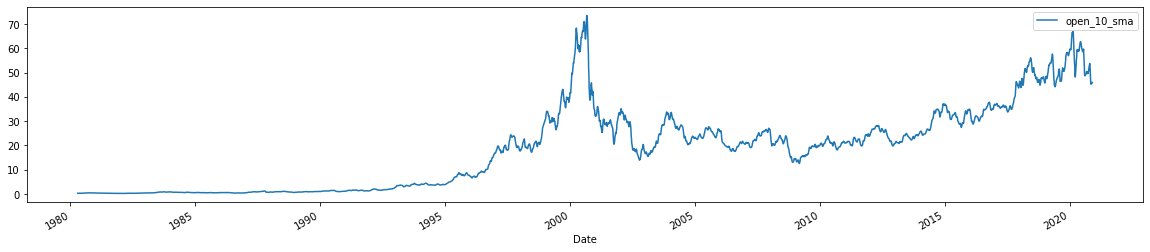

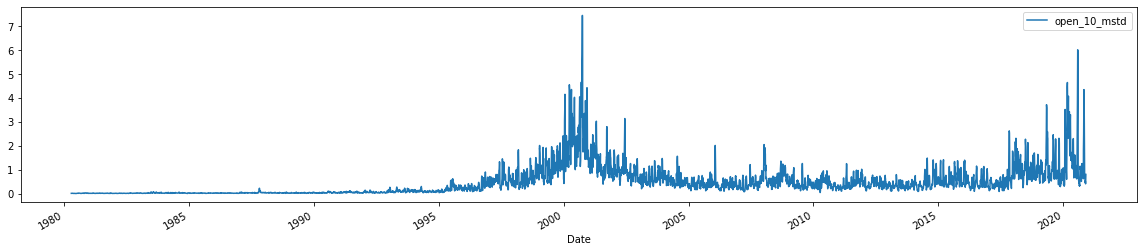

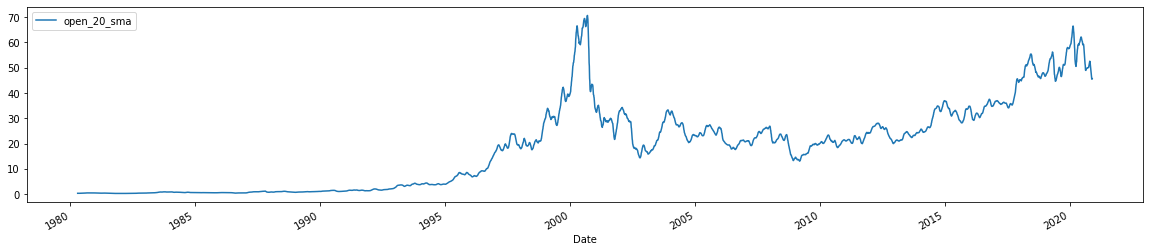

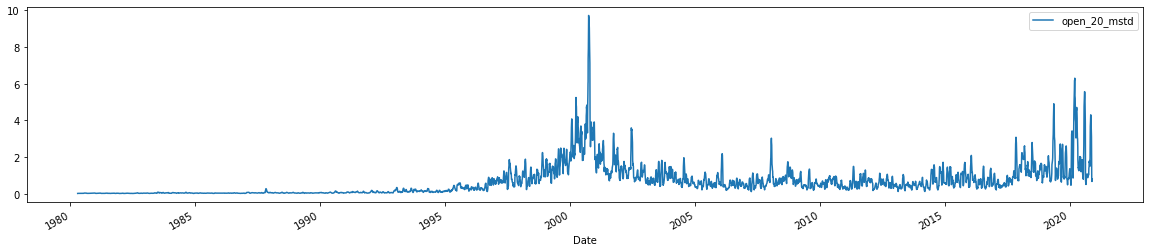

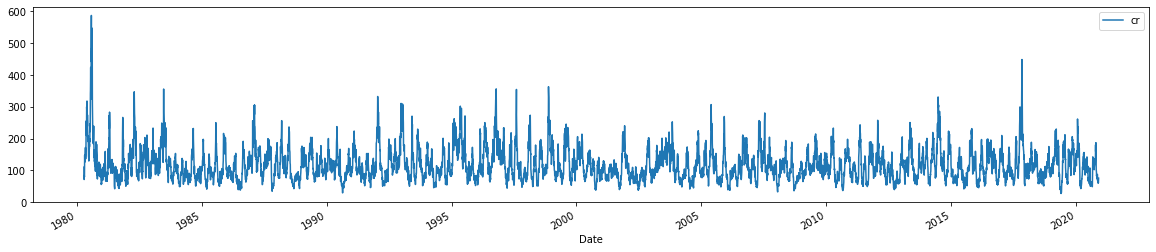

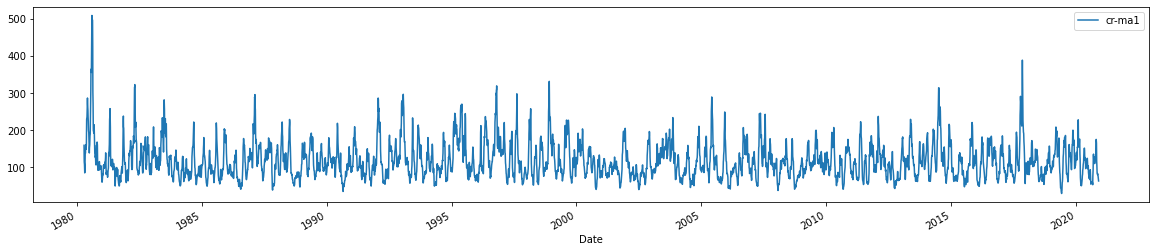

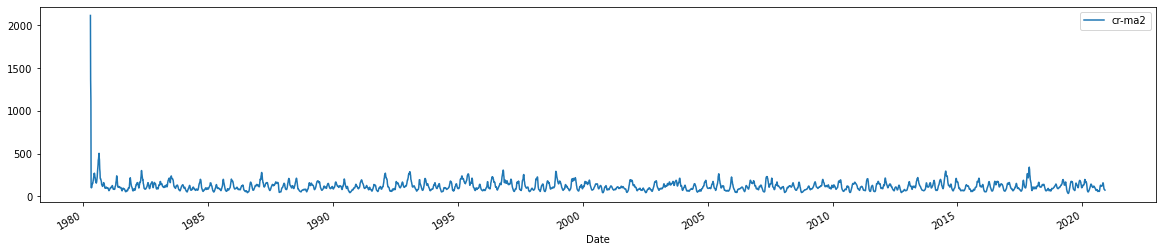

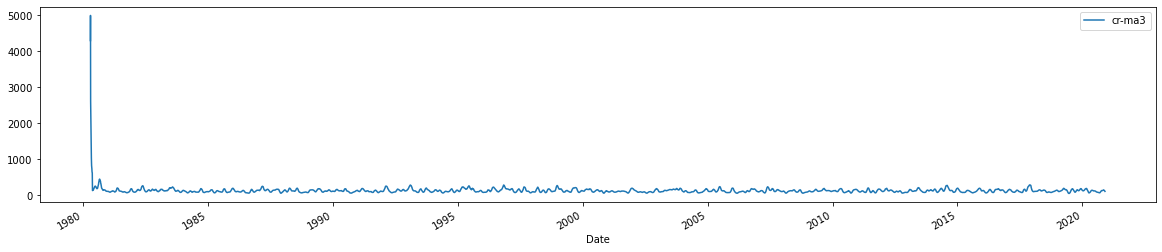

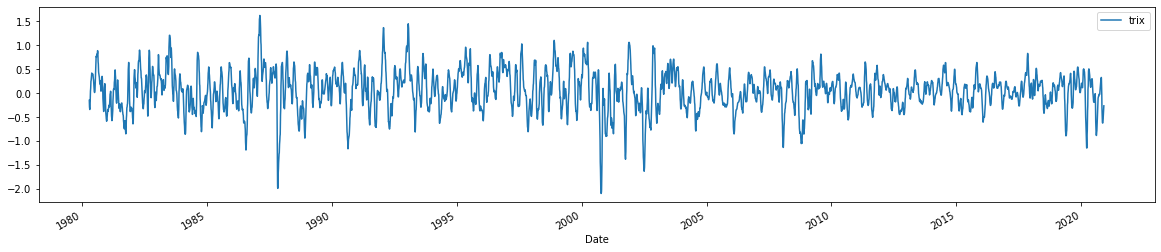

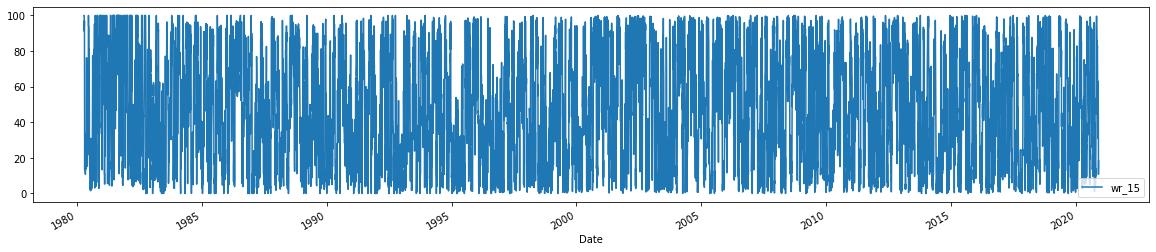

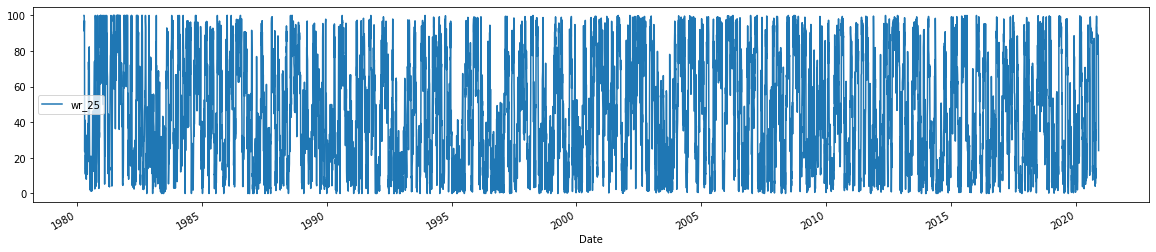

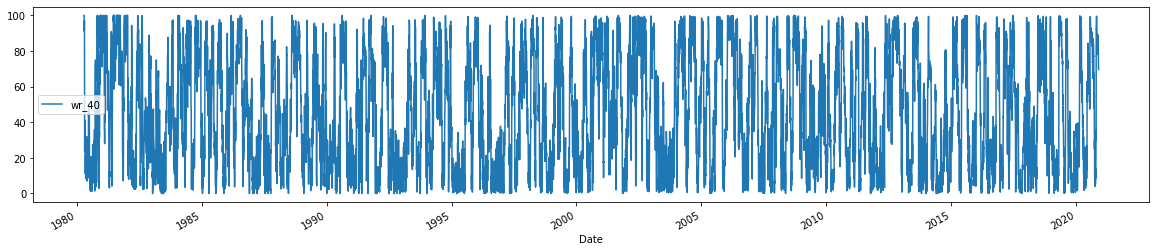

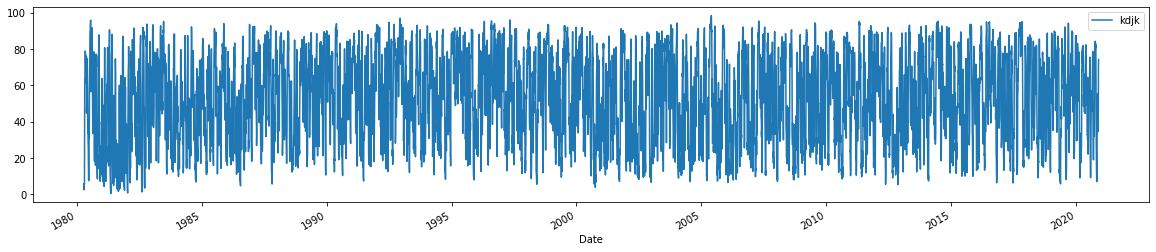

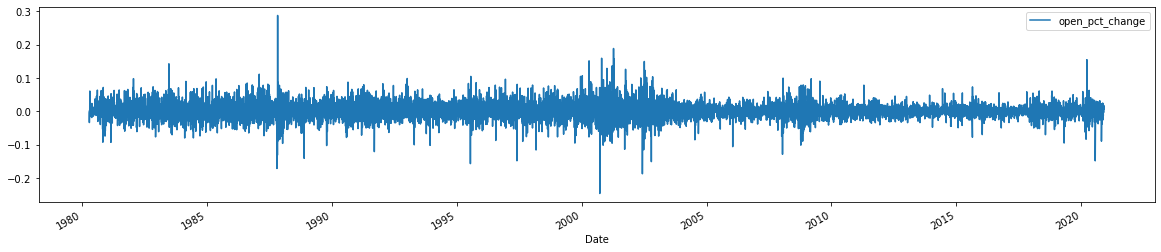

In [88]:
pd.options.plotting.backend = "matplotlib"
mpl.rcParams.update({'figure.max_open_warning': 0})
for col in df.columns:
    df[[col]].plot(figsize=(20,4))

In [89]:
# split

pivot_val="2020-03-28" #04
pivot_test="2020-07-28" #08
pred_col="open"
    
def compute_hurst(series):
    series = series.apply(np.exp)
    H, c, data = compute_Hc(series, kind='change', simplified=True)
    return H

df["hurst_100"] = df[pred_col].rolling(100).apply(compute_hurst)
df.dropna(inplace=True)

_train = df[df.index <= pd.Timestamp(pivot_val)]

_val = df[(df.index > pd.Timestamp(pivot_val)) & (df.index < pd.Timestamp(pivot_test))]

_test = df[df.index >= pd.Timestamp(pivot_test)]

In [90]:
train = _train.copy()
scalers={}
for i in train.columns:
    scaler = MinMaxScaler(feature_range=(0,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
    
test = _test.copy()
for i in test.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s
    
val = _val.copy()
for i in val.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(val[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    val[i]=s_s

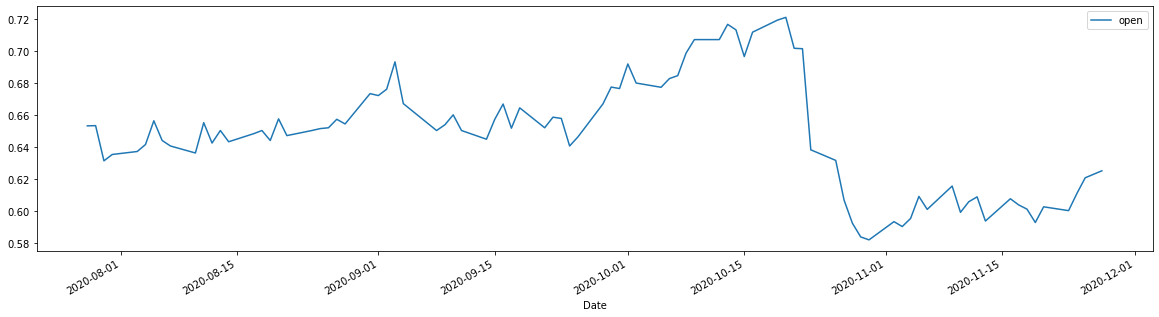

In [91]:
test[["open"]].plot(figsize=(20,5));

In [ ]:
%%time
# Prophet
n_past = 20
n_future = 10

print(_train.shape, _val.shape, _test.shape)
col = "open"
train_pr = _train.reset_index().rename({"Date": "ds", col: "y"}, axis=1)
val_pr = _val.reset_index().rename({"Date": "ds", col: "y"}, axis=1)
X_pr = pd.concat([train_pr, val_pr], axis=0)

preds = []
for i in range(test.shape[0] - n_past - n_future + 1):
    print(i)
    fbm = Prophet(weekly_seasonality='auto', daily_seasonality=True, seasonality_mode='additive')
    fbm.fit(df[(df.index < pd.Timestamp(pivot_test) + timedelta(days=n_future+i)) & (df.index > pd.Timestamp("2020-02-28"))].reset_index().rename({"Date": "ds", col: "y"}, axis=1));
    future = fbm.make_future_dataframe(periods=n_future) 
    prediction = fbm.predict(future)
    preds.append(prediction.iloc[-n_future:]["yhat"])
    print(prediction.iloc[-n_future:]["yhat"])
fbm.plot(prediction)
plt.title("Prediction of Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Open Stock Price")
plt.show()
prophet_preds = pd.DataFrame([x.values for x in preds])
prophet_preds.to_csv("prophet_preds.csv", index=False)

(9976, 44) (83, 44) (87, 44)
0
111    50.867119
112    51.788769
113    51.578137
114    50.436019
115    51.206886
116    50.769929
117    50.355678
118    49.392694
119    50.314343
120    50.103711
Name: yhat, dtype: float64
1
112    51.648545
113    51.433174
114    50.284628
115    51.033640
116    50.590543
117    50.171675
118    49.093772
119    50.140948
120    49.925577
121    48.777031
Name: yhat, dtype: float64
2
112    51.648545
113    51.433174
114    50.284628
115    51.033640
116    50.590543
117    50.171675
118    49.093772
119    50.140948
120    49.925577
121    48.777031
Name: yhat, dtype: float64
3
112    51.648545
113    51.433174
114    50.284628
115    51.033640
116    50.590543
117    50.171675
118    49.093772
119    50.140948
120    49.925577
121    48.777031
Name: yhat, dtype: float64
4
113    50.650023
114    50.194092
115    49.760181
116    48.682516
117    49.634430
118    49.404821
119    48.213905
120    49.042762
121    48.586831
122    48.152920
Nam

In [ ]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end + 1 > len(series):
            break
        past, future = series[window_start:past_end, :], series[past_end+1:future_end+1, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [ ]:
tmpe = test.copy()
tmpe["gg"] = test.index
tmpe["gg"] = tmpe["gg"].astype(str)
_, ind_test = split_series(tmpe[["gg"]].values, n_past, n_future)

In [ ]:
n_past = 20
n_future = 10
n_features = train.shape[1]
col = "open"
col_num = df.columns.get_loc(col)

X_train, _ = split_series(train.values,n_past, n_future)
_, y_train = split_series(train[[col]].values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

X_test, _ = split_series(test.values,n_past, n_future)
_, y_test = split_series(test[[col]].values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

X_val, y_val = split_series(val.values,n_past, n_future)
_, y_val = split_series(val[[col]].values,n_past, n_future)
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1],n_features))
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], 1))

In [ ]:
X_train.shape, X_val.shape, X_test.shape

In [ ]:
np.random.seed(42)
tf.random.set_seed(1)

In [ ]:
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(128, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(128, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

es = EarlyStopping(monitor='val_loss',
                   patience=20)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MAE, metrics=['MSE', 'MAPE'])
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val),batch_size=32,verbose=1,callbacks=[es, reduce_lr], shuffle=False)

In [ ]:
history = history_e1d1
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred_e1d1=model_e1d1.predict(X_test)
val_e1d1=model_e1d1.predict(X_val)

In [ ]:
scaler = scalers['scaler_' + col]

pred_e1d1=scaler.inverse_transform(pred_e1d1.reshape(*pred_e1d1.shape[:2]))

val_e1d1=scaler.inverse_transform(val_e1d1.reshape(*val_e1d1.shape[:2]))

y_train=scaler.inverse_transform(y_train.reshape(*y_train.shape[:2]))

y_test=scaler.inverse_transform(y_test.reshape(*y_test.shape[:2]))

y_val=scaler.inverse_transform(y_val.reshape(*y_val.shape[:2]))

In [ ]:
mpl.rcParams.update({'figure.max_open_warning': 0})
errors = []
for i in range(y_val.shape[1]):
    fig, ax = plt.subplots(figsize=(25, 4))
    plt.plot(y_val[:,i], label='real');
    plt.plot(val_e1d1[:,i], label='val');
    plt.title(str(mean_squared_error(y_val[:,i],val_e1d1[:,i])) +"  |||  " + str(mean_squared_error(y_val[:,i],val_e1d1[:,i]-2)))
    errors.append([mean_squared_error(y_val[:,i],val_e1d1[:,i]), mean_squared_error(y_val[:,i],val_e1d1[:,i]-2)])
    plt.plot(val_e1d1[:,i]-2, label='val-2');
    plt.legend();

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


coefs = []
for i in range(10):
    reg = LinearRegression().fit(val_e1d1[i,:].reshape(-1, 1), y_val[i,:].reshape(-1, 1))
    coefs.append(reg.coef_)
    print(np.array(coefs).mean(), "\n",
    mean_squared_error(y_val,val_e1d1), mean_squared_error(y_val,val_e1d1+np.array(coefs).mean()), "\n", 
    mean_absolute_percentage_error(y_val,val_e1d1), mean_absolute_percentage_error(y_val,val_e1d1+np.array(coefs).mean()))

In [ ]:
mean_squared_error(y_test,pred_e1d1), mean_squared_error(y_test,pred_e1d1+np.array(coefs).mean()), mean_absolute_percentage_error(y_test,pred_e1d1), mean_absolute_percentage_error(y_test,pred_e1d1+np.array(coefs).mean())

In [ ]:
mpl.rcParams.update({'figure.max_open_warning': 0})
test_errors = []
lstm = []
real = []
prophet = []
for i in range(0,y_test.shape[0],4):
    fig, ax = plt.subplots(figsize=(25, 4))
    plt.plot(y_test[i,:], label='real');
    plt.locator_params(axis="x", nbins=10)
    real.append(y_test[i,:])
    plt.plot(pred_e1d1[i,:], label='pred_lstm');
    lstm.append(pred_e1d1[i,:])
    plt.plot(prophet_preds.loc[i,:].values, label='pred_prophet');
    prophet.append(prophet_preds.loc[i,:])
    plt.title("MAPE: " + str(mean_absolute_percentage_error(y_test[i,:],pred_e1d1[i,:])) + " || " + str(mean_absolute_percentage_error(y_test[i,:],prophet_preds.loc[i,:].values)))
    test_errors.append([mean_absolute_percentage_error(y_test[i,:],pred_e1d1[i,:]), mean_absolute_percentage_error(y_test[i,:],prophet_preds.loc[i,:])])
    ax.set_xticklabels(pd.DataFrame(ind_test[i,:].flatten()).astype(str).values.flatten(), rotation=0);
    plt.legend();

In [ ]:
mpl.rcParams.update({'figure.max_open_warning': 0})
test_errors = []
lstm = []
real = []
prophet = []
for i in range(0,y_test.shape[0],1):
    fig, ax = plt.subplots(figsize=(20, 4))
    plt.plot(y_test[i,:], label='real');
    plt.locator_params(axis="x", nbins=10)
    real.append(y_test[i,:])
    plt.plot(pred_e1d1[i,:], label='pred_lstm');
    lstm.append(pred_e1d1[i,:])
    plt.title("MAPE: " + str(mean_absolute_percentage_error(y_test[i,:],pred_e1d1[i,:])))
    test_errors.append([mean_squared_error(y_test[i,:],pred_e1d1[i,:]), mean_absolute_percentage_error(y_test[i,:],pred_e1d1[i,:])])
    ax.set_xticklabels(pd.DataFrame(ind_test[i,:].flatten()).astype(str).values.flatten(), rotation=0);
    plt.legend();

In [ ]:
np.array(test_errors).mean(axis=0)

In [ ]:
mpl.rcParams.update({'figure.max_open_warning': 0})
test_errors = []
lstm = []
real = []
prophet = []
for i in range(0,y_test.shape[0],1):
    #fig, ax = plt.subplots(figsize=(20, 4))
    #plt.plot(y_test[i,:], label='real');
    #plt.locator_params(axis="x", nbins=10)
    #real.append(y_test[i,:])
    #lstm.append(pred_e1d1[i,:])
    #plt.plot(prophet_preds.loc[i,:].values, label='pred_prophet');
    #prophet.append(prophet_preds.loc[i,:])
    #plt.title("MAPE: " + str(mean_absolute_percentage_error(y_test[i,:],prophet_preds.loc[i,:].values)))
    test_errors.append([mean_squared_error(y_test[i,:],prophet_preds.loc[i,:].values), mean_absolute_percentage_error(y_test[i,:],prophet_preds.loc[i,:].values)])
    #ax.set_xticklabels(pd.DataFrame(ind_test[i,:].flatten()).astype(str).values.flatten(), rotation=0);
    #plt.legend();

In [ ]:
np.array(test_errors).mean(axis=0)

In [ ]:
pd.DataFrame(ind_test.reshape(*ind_test.shape[:2])).to_csv("times.csv")

In [ ]:
df.loc[(df.index == pd.Timestamp("2020-10-08")) | (df.open == 52.91)]

In [ ]:
df.loc[(df.index == pd.Timestamp("2020-10-08")) | (df.index <= pd.Timestamp("2020-10-28")), "open"].plot(figsize=(20,4));

In [ ]:
__df = df.copy()
__df.loc[(__df.index >= pd.Timestamp("2020-08-08")) & (__df.index <= pd.Timestamp("2020-08-21")), ["open"]] = pred_e1d1[30]

In [ ]:
__df.loc[(__df.index >= pd.Timestamp("2020-06-08")) & (__df.index <= pd.Timestamp("2020-08-21")), ["open"]]

In [ ]:
df.loc[(df.index >= pd.Timestamp("2020-08-08")) & (df.index <= pd.Timestamp("2020-08-21")), ["open"]]

In [ ]:
df.loc[(df.index >= pd.Timestamp("2020-08-08")) & (df.index <= pd.Timestamp("2020-10-21")), ["open"]]#.append()

In [ ]:
ax = pd.DataFrame(np.array(lstm).flatten()).plot(figsize=(25,10));
pd.DataFrame(np.array(real).flatten()).plot(figsize=(25,10), ax=ax);
pd.DataFrame(np.array(prophet).flatten()).plot(figsize=(25,10), ax=ax);

In [ ]:
np.array(errors).mean(axis=0)

In [ ]:
model_e1d1.save("model_e1d1.h5")
model = load_model('model_e1d1.h5')

In [ ]:
win = [0, 9]
ax = pd.DataFrame(pred_e1d1).loc[:,win].plot(figsize=(25,10));
pd.DataFrame(y_test).loc[:,[0]].plot(figsize=(25,10), ax=ax);
plt.legend(["Prediction LSTM day " + str(el+1) for el in win] + ["Real values"]);
ax.set_xticklabels(pd.DataFrame(ind_test[:,0].flatten()).astype(str).values.flatten()[::6], rotation=0);
plt.title("MAPE: " + str({"day" + str(el+1): np.round(val,2) for el,val 
                          in zip(win, [mean_absolute_percentage_error(pd.DataFrame(y_test).loc[:,[0]].values, pd.DataFrame(pred_e1d1).loc[:,w]) for w in win])}));

In [ ]:
win = [0, 9]
prophet_preds.columns = pd.DataFrame(pred_e1d1).columns
ax = pd.DataFrame(prophet_preds).loc[:,win].plot(figsize=(25,10));
pd.DataFrame(y_test).loc[:,[0]].plot(figsize=(25,10), ax=ax);
plt.legend(["Prediction Prophet day " + str(el+1) for el in win] + ["Real values"]);
ax.set_xticklabels(pd.DataFrame(ind_test[:,0].flatten()).astype(str).values.flatten()[::6], rotation=0);
plt.title("MAPE: " + str({"day" + str(el+1): np.round(val,2) for el,val 
                          in zip(win, [mean_absolute_percentage_error(pd.DataFrame(y_test).loc[:,[0]].values, pd.DataFrame(prophet_preds).loc[:,w]) for w in win])}));

In [ ]:
pd.DataFrame(pred_e1d1)#.to_csv("lstm_results.csv")

In [ ]:
ind_test[:,1].flatten()[0].day()

In [ ]:
plt.plot(prophet_preds.apply(list, axis=1).sum());

In [ ]:
pd.DataFrame([df[(df.index > pd.Timestamp(pivot_test) + timedelta(days=20 + i)) & (df.index < pd.Timestamp(pivot_test) + timedelta(days=50 + i))]["open"].values for i in range(66)])

In [ ]:
ind_test[:,1].flatten()

In [ ]:
pred_e1d1.to_csv("pred_e1d1.csv")

In [ ]:
__df = df.copy()
__df["open_pct_change"] = __df["open"].pct_change()

__df.dropna(inplace=True)

__df["class_open"] = __df["open_pct_change"].clip(-0.05,0.05).apply(lambda x: int(x*100))
__df["class_open_lag_1"] = __df["class_open"].shift(1)
__df.dropna(inplace=True)

__df["class_open_lag_1"] = __df["class_open_lag_1"].astype(int)
__df.loc[(__df.index >= pd.Timestamp("2020-08-08")) & (__df.index <= pd.Timestamp("2020-08-21")), ["open"]] = pred_e1d1[30]
__df = __df[(__df.index >= pd.Timestamp("2020-06-21")) & (__df.index <= pd.Timestamp("2020-08-21"))][["open", "class_open", "class_open_lag_1"]]

mark_df = (__df.groupby(["class_open", "class_open_lag_1"]).count()/(__df.shape[0]))["Open"].reset_index()#.rolling(20)
pivot = mark_df.pivot_table(index=["class_open"], columns=["class_open_lag_1"], values="Open")
pivot = pivot.apply(lambda x: x/x.sum(), axis=1)
pivot.fillna(0, inplace=True)
pivot

j = sym.Symbol('j')
i = sym.Symbol('i')
m = sym.Matrix([[f"m_{i}" for i in range(pivot.shape[0])]]).T
P = sym.Matrix(pivot.values)

%%time
solutions = []
for k in range(pivot.shape[0]):
    solution = sym.solve((m[i] - 1 - sum([(P[i,j]*m[j]) for j in range(pivot.shape[1])]) if i!=k else m[i] for i in range(pivot.shape[0])), tuple((m[i] for i in range(pivot.shape[0]))))
    solutions.append(solution)

__df["mean_time"] = __df["class_open"].apply(lambda x: exps.T[exps.index < -4].T.loc[x].values[0])

__df[["mean_time"]].plot(figsize=(20,4));
plt.vlines(pd.Timestamp("2020-08-10"),ymin=0, ymax=__df["mean_time"].max(),linestyles='solid', color="g", label="start of prognosis")
plt.title("Mean time before 5% price drop");
plt.legend();

exps.T[exps.index < -4].T.loc[-3].values[0]

exps = pd.DataFrame(solutions, index=pivot.index)
exps.columns = pivot.columns
exps.apply(lambda a: min(enumerate(a), key=lambda x: x[1] if x[1] > 0 else float('inf'))[1], axis=1)
for col in exps.columns:
    exps[col] = exps[col].astype(float)
exps.replace({0:np.inf}).idxmin(axis=1)